# Beginning

In [1]:
clear all
node = [0,0; 1,0; 1,1; 0,1];
elem = [2,3,1; 4,1,3];

for k = 1:1
    [node,elem] = uniformrefine(node,elem);
end

# Preprocess

In [2]:
if ~exist('bdFlag','var'), bdFlag = []; end
if ~exist('option','var'), option = []; end

% Homogenous Dirichlet boundary condition
pde.f = inline('ones(size(p,1),1)','p');
pde.g_D = 0;

N = size(node,1); 
NT = size(elem,1);
Ndof = N;
option = [];
time = cputime;

if ~isfield(pde,'d')
   pde.d = [];
end % True

if ~isfield(option,'dquadorder')
   option.dquadorder = 1;
end

[Dphi,area] = gradbasis(node,elem);

# Assemble stiffness matrix

In [3]:
A = sparse(Ndof,Ndof);

for i = 1:3
    for j = i:3
        % $A_{ij}|_{\tau} = \int_{\tau}K\nabla \phi_i\cdot \nabla \phi_j dxdy$ 
        Aij = (Dphi(:,1,i).*Dphi(:,1,j) + Dphi(:,2,i).*Dphi(:,2,j)).*area;
        if (j==i)
            A = A + sparse(elem(:,i),elem(:,j),Aij,Ndof,Ndof);
        else
            A = A + sparse([elem(:,i);elem(:,j)],[elem(:,j);elem(:,i)],...
                           [Aij; Aij],Ndof,Ndof);        
        end
    end
end

% clear K Aij

% A = sparse(Ndof,Ndof);
% 
% i = 1;
% j = 2;
% Aij = (Dphi(:,1,i).*Dphi(:,1,j) + Dphi(:,2,i).*Dphi(:,2,j)).*area;
% sparse(elem(:,i),elem(:,j),Aij,Ndof,Ndof)
% sparse([elem(:,i);elem(:,j)],[elem(:,j);elem(:,i)],...
%                            [Aij; Aij],Ndof,Ndof)
% [[elem(:,i);elem(:,j)], [elem(:,j);elem(:,i)]]


ans = 

  Patch with properties:

    FaceColor: [0.5000 0.9000 0.4500]
    FaceAlpha: 1
    EdgeColor: [0 0 0]
    LineStyle: '-'
        Faces: [8x3 double]
     Vertices: [9x3 double]

  Use GET to show all properties




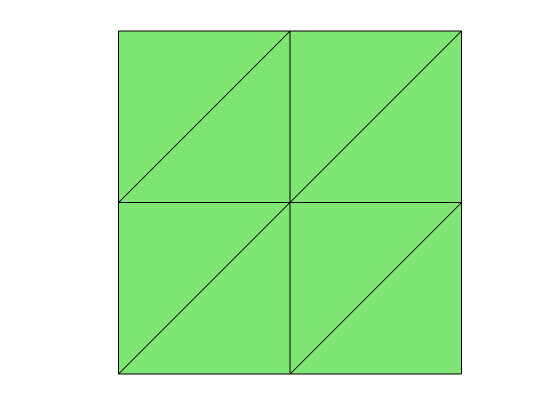

In [4]:
showmesh(node,elem)

# Assemble the right hand side

In [5]:
b = zeros(Ndof,1);
if ~isfield(option,'fquadorder')
    option.fquadorder = 3;   % default order
end

if ~isempty(pde.f) && ~isreal(pde.f)  % f is a function 
    [lambda,weight] = quadpts(option.fquadorder);
    phi = lambda;        % linear bases
	nQuad = size(lambda,1);
    bt = zeros(NT,3);
    for p = 1:nQuad
		% quadrature points in the x-y coordinate
		pxy = lambda(p,1)*node(elem(:,1),:) ...
			+ lambda(p,2)*node(elem(:,2),:) ...
			+ lambda(p,3)*node(elem(:,3),:);
		fp = pde.f(pxy);
        for i = 1:3
            bt(:,i) = bt(:,i) + weight(p)*phi(p,i)*fp;
        end
    end
    bt = bt.*repmat(area,1,3);
    b = accumarray(elem(:),bt(:),[Ndof 1]);
end
% clear pxy bt

% getbd
u = zeros(Ndof,1); 
%% Initial check
if ~isfield(pde,'g_D'), pde.g_D = []; end
if ~isfield(pde,'g_N'), pde.g_N = []; end
if ~isfield(pde,'g_R'), pde.g_R = []; end

In [6]:
lambda


lambda =

    0.3333    0.3333    0.3333
    0.6000    0.2000    0.2000
    0.2000    0.6000    0.2000
    0.2000    0.2000    0.6000




# Part 1: Modify the matrix for Dirichlet and Robin condition

## Robin boundary condition

In [7]:
Robin = [];
isRobin = (bdFlag(:) == 3);

if any(isRobin)
    allEdge = [elem(:,[2,3]); elem(:,[3,1]); elem(:,[1,2])];
    Robin = allEdge(isRobin,:);
end

if ~isempty(Robin) && ~isempty(pde.g_R) && ~(isnumeric(pde.g_R) && (pde.g_R == 0))
    ve = node(Robin(:,1),:) - node(Robin(:,2),:);
    edgeLength = sqrt(sum(ve.^2,2)); 
    mid = (node(Robin(:,1),:) + node(Robin(:,2),:))/2;
    % use Simplson rule to compute int g_R phi_iphi_j ds
    ii = [Robin(:,1),Robin(:,1),Robin(:,2),Robin(:,2)];
    jj = [Robin(:,1),Robin(:,2),Robin(:,1),Robin(:,2)];
    temp = pde.g_R(mid).*edgeLength;
    ss = [1/3*temp, 1/6*temp, 1/6*temp, 1/3*temp];
    A = A + sparse(ii,jj,ss,Ndof,Ndof);
end

## mFind Dirichlet boundary nodes: fixedNode

In [8]:
fixedNode = []; freeNode = [];
if ~isempty(bdFlag) % find boundary edges and boundary nodes
    [fixedNode,bdEdge,isBdNode] = findboundary(elem,bdFlag);
    freeNode = ~isBdNode;
end
if isempty(bdFlag) && ~isempty(pde.g_D) && isempty(pde.g_N) && isempty(pde.g_R)
    % no bdFlag, only pde.g_D is given
    [fixedNode,bdEdge,isBdNode] = findboundary(elem);
    freeNode = ~isBdNode;
end
% Modify the matrix for different boundary conditions 
% Dirichlet boundary condition
% Build Dirichlet boundary condition into the matrix AD by enforcing
% AD(fixedNode,fixedNode)=I, AD(fixedNode,freeNode)=0, AD(freeNode,fixedNode)=0.
if ~isempty(fixedNode)
    bdidx = zeros(Ndof,1); 
    bdidx(fixedNode) = 1;
    Tbd = spdiags(bdidx,0,Ndof,Ndof);
    T = spdiags(1-bdidx,0,Ndof,Ndof);
    AD = T*A*T + Tbd;
end
% Neumann boundary condition
isPureNeumann = false;
if isempty(fixedNode) && isempty(Robin) % pure Neumann boundary condition
    isPureNeumann = true;
    AD = A;
    AD(1,1) = AD(1,1) + 1e-6;
%         fixedNode = 1;
%         freeNode = 2:Ndof;    % eliminate the kernel by enforcing u(1) = 0;
end
% Robin boundary condition
if isempty(fixedNode) && ~isempty(Robin)
    AD = A;
end

# Part 2: Find boundary edges and modify the right hand side b


## Find boundary edges: Neumann

In [9]:
Neumann = []; 
if ~isempty(bdFlag)  % bdFlag specifies different bd conditions
    Neumann = bdEdge;        
end
if isempty(bdFlag) && (~isempty(pde.g_N) || ~isempty(pde.g_R))
    % no bdFlag, only pde.g_N or pde.g_R is given in the input
    [tempvar,Neumann] = findboundary(elem); 
end



# Neumann boundary condition

In [10]:
if  isnumeric(pde.g_N) && all(pde.g_N == 0)
    pde.g_N = [];
end
if ~isempty(Neumann) && ~isempty(pde.g_N)
    el = sqrt(sum((node(Neumann(:,1),:) - node(Neumann(:,2),:)).^2,2));
    if ~isfield(option,'gNquadorder')
        option.gNquadorder = 2;   % default order exact for linear gN
    end
    [lambdagN,weightgN] = quadpts1(option.gNquadorder);
    phigN = lambdagN;                 % linear bases
    nQuadgN = size(lambdagN,1);
    ge = zeros(size(Neumann,1),2);
    for pp = 1:nQuadgN
        % quadrature points in the x-y coordinate
        ppxy = lambdagN(pp,1)*node(Neumann(:,1),:) ...
             + lambdagN(pp,2)*node(Neumann(:,2),:);
        gNp = pde.g_N(ppxy);
        for igN = 1:2
            ge(:,igN) = ge(:,igN) + weightgN(pp)*phigN(pp,igN)*gNp;
        end
    end
    ge = ge.*repmat(el,1,2);
    b = b + accumarray(Neumann(:), ge(:),[Ndof,1]); 
end
% The case with non-empty Neumann edges but g_N=0 or g_N=[] corresponds to
% the zero flux boundary condition on Neumann edges and no modification of
% A,u,b is needed.


# Dirichlet boundary condition

In [11]:
if isnumeric(pde.g_D) && all(pde.g_D == 0)   % zero g_D
    pde.g_D = [];
end
if ~isPureNeumann && ~isempty(fixedNode) && ~isempty(pde.g_D)
    if isnumeric(pde.g_D)  % pde.g_D could be a numerical array 
        u(fixedNode) = pde.g_D(fixedNode); 
    else % pde.g_D is a function handle
        u(fixedNode) = pde.g_D(node(fixedNode,:));
    end
    b = b - A*u;
end
if ~isempty(fixedNode) % non-empty Dirichlet boundary condition
    b(fixedNode) = u(fixedNode);
end

# Pure Neumann boundary condition

In [12]:
% The case with non-empty Dirichlet nodes but g_D=0 or g_D=[] corresponds
% to the zero Dirichlet boundary condition and no modification of u,b is
% needed.

if isPureNeumann
    b = b - mean(b); % compatiable condition (f,1) + <gN,1> = 0
%         b(1) = 0;
end

# Record assembling time

In [13]:
assembleTime = cputime - time;
if ~isfield(option,'printlevel'), option.printlevel = 1; end
if option.printlevel >= 2
    fprintf('Time to assemble matrix equation %4.2g s\n',assembleTime);
end


# Solve the system of linear equations

In [14]:
if isempty(freeNode), return; end
% Set up solver type
if isempty(option) || ~isfield(option,'solver')  || isfield(option,'mgoption')   % no option.solver
    if Ndof <= 2e3  % Direct solver for small size systems
        option.solver = 'direct';
    else            % MGCG  solver for large size systems
        option.solver = 'mg';
    end
end
if isPureNeumann
    option.solver = 'mg';
end
solver = option.solver;

# Solve

In [15]:

switch solver
    case 'direct'
        t = cputime;
        u(freeNode) = AD(freeNode,freeNode)\b(freeNode);
        residual = norm(b - AD*u);
        info = struct('solverTime',cputime - t,'itStep',0,'err',residual,'flag',2,'stopErr',residual);
    case 'none'
        info = struct('solverTime',[],'itStep',0,'err',[],'flag',3,'stopErr',[]);
    case 'mg'
        if ~isfield(option,'mgoption')   % no option.mgoption
            option.mgoption.x0 = u;
            option.mgoption.solver = 'CG';
        end
        [u,info] = mg(AD,b,elem,option.mgoption);
    case 'amg'
        if ~isfield(option,'amgoption')  % no option.amgoption
            option.amgoption.x0 = u;
            option.amgoption.solver = 'CG';
        end
        [u(freeNode),info] = amg(AD(freeNode,freeNode),b(freeNode),option.amgoption);                 
end

% post-process for pure Neumann problem
if isPureNeumann
    patchArea = accumarray(elem(:),[area;area;area]/3, [N 1]);
    uc = sum(u.*patchArea)/sum(area);
    u = u - uc;   % int u = 0
end


# Output

In [16]:
soln = struct('u',u);
eqn = struct('A',AD,'b',b,'freeNode',freeNode,'Lap',A);
info.assembleTime = assembleTime;

In [69]:
clear all
node = [0,0; 1,0; 1,1; 0,1];
elem = [2,3,1; 4,1,3];      
for k = 1:2
  [node,elem] = uniformrefine(node,elem);
end
% Homogenous Dirichlet boundary condition
pde.f = inline('ones(size(p,1),1)','p');
pde.g_D = 0;
u = Poisson(node,elem,[],pde);
% figure(1); 
% showresult(node,elem,u);
max(u)


ans =

   0.070312500000000




In [70]:
u


u =

                   0
                   0
                   0
                   0
                   0
   0.070312500000000
                   0
                   0
                   0
                   0
   0.042968750000000
                   0
                   0
                   0
   0.042968750000000
                   0
                   0
                   0
                   0
   0.054687500000000
   0.042968750000000
   0.054687500000000
   0.054687500000000
   0.054687500000000
   0.042968750000000




In [78]:
clear all
node = [0,0; 1,0; 1,1; 0,1];
elem = [2,3,1; 4,1,3];
for k = 1:5
[node,elem] = uniformrefine(node,elem);
end
% Homogenous Dirichlet boundary condition
pde.f = inline('ones(size(p,1),1)','p');
pde.g_D = 0;
u = PoissonP2(node,elem,[],pde);
max(u)


 Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     3969,  #nnz:    38441, smoothing: (1,1), iter: 12,   err = 2.23e-10,   time = 0.031 s

ans =

   0.073671370693928




In [76]:
length(u)


ans =

    81




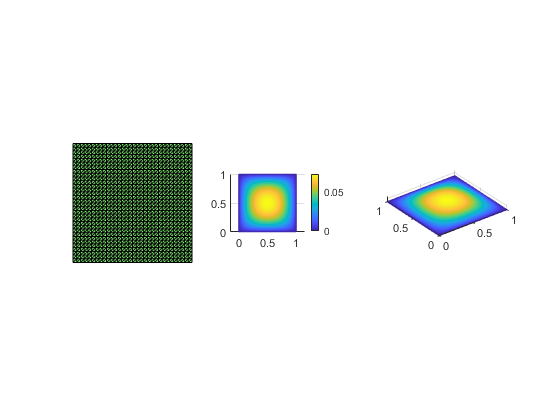

In [79]:
showresult(node,elem,u);

In [1]:
open PoissonP2

In [1]:
ifem introduction


 Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     3969,  #nnz:    38441, smoothing: (1,1), iter: 12,   err = 2.23e-10,   time = 0.11 s



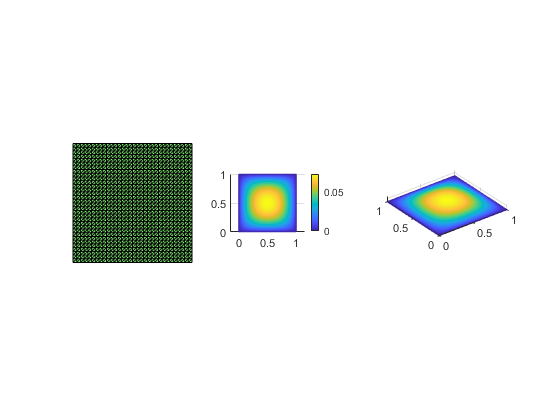

In [3]:
clear all
node = [0,0; 1,0; 1,1; 0,1];
elem = [2,3,1; 4,1,3];      
for k = 1:5
  [node,elem] = uniformrefine(node,elem);
end
% Homogenous Dirichlet boundary condition
pde.f = inline('ones(size(p,1),1)','p');
pde.g_D = 0;
u = PoissonP2(node,elem,[],pde);
figure(1); 
showresult(node,elem,u);

In [4]:
ifem introduction


elem =

     8     6     2
     7     6     4
     5     6     1
     9     6     3
     8     3     6
     7     1     6
     5     2     6
     9     4     6




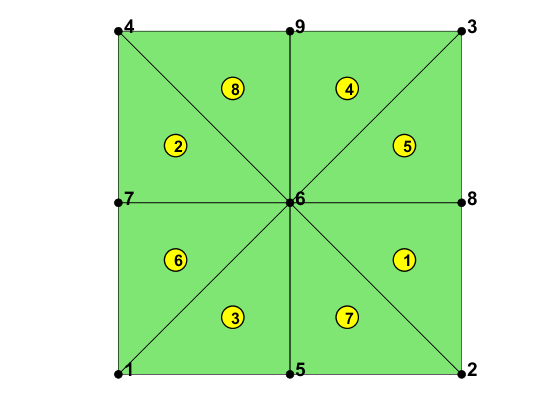

In [5]:
node = [0,0; 1,0; 1,1; 0,1];
elem = [2,3,1; 4,1,3];      
[node,elem] = uniformbisect(node,elem);
figure('rend','painters','pos',[10 10 225 225])
showmesh(node,elem);
findnode(node);
findelem(node,elem);
display(elem);

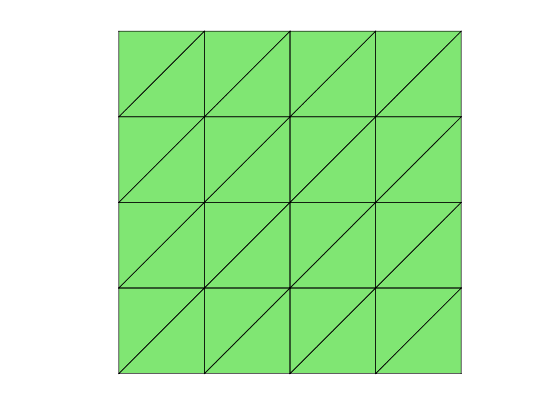

In [7]:
[node,elem] = squaremesh([0,1,0,1],0.25); 
mesh = struct('node',node,'elem',elem);
figure('rend','painters','pos',[10 10 225 225])
showmesh(node,elem);
option.L0 = 3;
option.maxIt = 4;
option.printlevel = 1;


 Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:     4032,  #nnz:    19906, smoothing: (1,1), iter: 10,   err = 1.55e-09,   time = 0.016 s

 Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:    16256,  #nnz:    80770, smoothing: (1,1), iter: 10,   err = 1.55e-09,   time = 0.13 s

 Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:    65280,  #nnz:   325378, smoothing: (1,1), iter: 10,   err = 1.47e-09,   time = 0.19 s

 Multigrid V-cycle Preconditioner with Conjugate Gradient Method
#dof:   261632,  #nnz:  1306114, smoothing: (1,1), iter: 10,   err = 1.38e-09,   time = 0.78 s

 #Dof        h        ||u-u_h||    ||Du-Du_h||   ||DuI-Du_h|| ||uI-u_h||_{max}

  4225   1.563e-02   2.88013e-04   5.45135e-02   5.54571e-04   2.26928e-04
 16641   7.813e-03   7.20310e-05   2.72601e-02   1.38693e-04   5.67600e-05
 66049   3.906e-03   1.80095e-05   1.36305e-02   3.46767e-05   1.41918e-05
263169   1.953e-03   4.50250e-06   6.81528e-03   

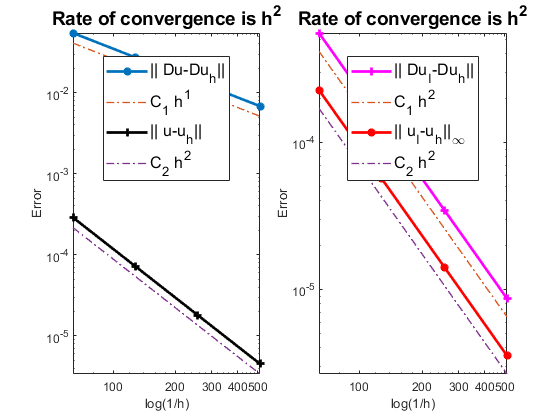

In [8]:
option.plotflag = 0;
pde = sincosdata;
mesh.bdFlag = setboundary(node,elem,'Dirichlet','~(x==0)','Neumann','x==0');
femPoisson(mesh,pde,option);

In [9]:
open femPoisson

In [10]:
option


option = 

  struct with fields:

            L0: 3
         maxIt: 4
    printlevel: 1
      plotflag: 0




In [12]:
open getH1error

In [17]:
help getL2error

  GETL2ERROR L2 norm of the approximation error.
 
   err = getL2error(node,elem,@uexact,uh) computes the L2 norm of the error
   between the exact solution uexact and a finite element approximation uh
   on a mesh described by node and elem.
 
   The input parameter uexact is a function handle and uh is a column array
   which could be:
     - P0 element i.e. discontinuous and piecewise constant
     - P1 element i.e. continuous and piecewise linear
     - CR element i.e. piecewise linear and continuous at mid pts of edges
     - P2 element i.e. continuous and piecewise quadratic
     - P1+P0 element which could happen in the fluid application
 
   err = getL2error(node,elem,@uexact,uh,quadOrder) computes error
   using the quadrature rule with order quadOrder (up to 5). The default
   order is 3.
    
   Example: compute L2 error of piecewise linear interpolation
 
      [node,elem] = squaremesh([0,1,0,1],0.25);
      for k = 1:4
          exactu = inline('sin(pi*pxy(:,1)).*sin(pi*px

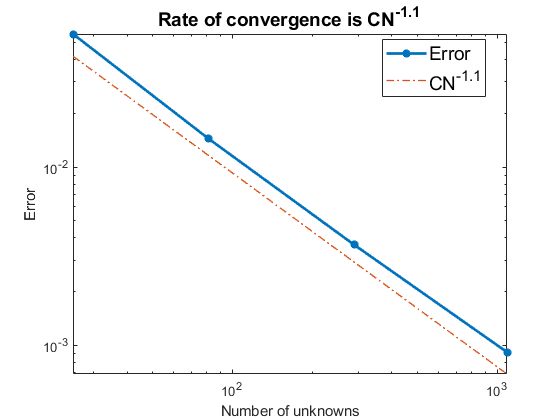

In [19]:
[node,elem] = squaremesh([0,1,0,1],0.25);
  for k = 1:4
      exactu = inline('sin(pi*pxy(:,1)).*sin(pi*pxy(:,2))','pxy');
      uI = exactu(node);
      N(k) = size(node,1);
      err(k) = getL2error(node,elem,exactu,uI);
      [node,elem] = uniformrefine(node,elem);
  end
  showrate(N,err);

In [20]:
open getL2error